# Averaging Function Testing
## Imorting relevant directories

In [1]:
from pathlib import Path
import sys
sys.path.append('../')
from pma_open import *
from skimage.util.shape import view_as_blocks
from scipy.ndimage import gaussian_filter
from skimage.feature import peak_local_max


## Naming relevant paths


In [2]:
file_path = '../pma files/hel1.pma'

## Average Frame Array function (avg_frame_arr)

In [3]:
#Testing avg_frame_arr function
avg_frame_data = avg_frame_arr(file_path)

Image Size: 512 x 512
Sucessfully generated average frame


In [4]:
print(f"Average Frame Data- shape: {avg_frame_data.shape}")
print(f"Average Frame Data- Type: {type(avg_frame_data)}")
print(f"Average Frame Data- dType: {avg_frame_data.dtype}")
# print(f"First line of Average Frame Data: {avg_frame_data[0]}")

Average Frame Data- shape: (512, 512)
Average Frame Data- Type: <class 'numpy.ndarray'>
Average Frame Data- dType: uint8


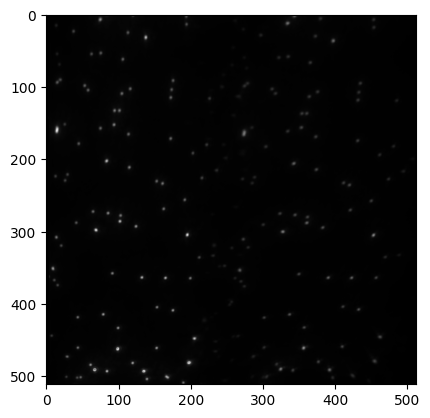

In [5]:
#Display Average frame using matplotlib
image = plt.imshow(avg_frame_data, cmap="grey");

## Average Frame png function (avg_frame_png)

In [6]:
#Testing avg_frame_png function
avg_frame_png(file_path)

Image Size: 512 x 512
Image Size: 512 x 512
Sucessfully generated average frame
Average frame saved as: hel1_Avg_Frame.png


<class 'numpy.ndarray'>
uint8
(512, 512)
7 213


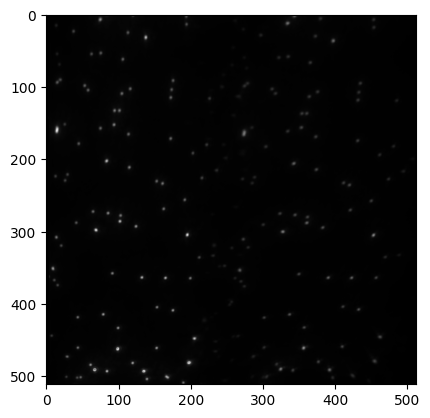

In [7]:
image_path = "hel1_Avg_Frame/hel1_Avg_Frame.png"
hel1_avg_image = io.imread(image_path)

# show the image
print(type(hel1_avg_image))
print(hel1_avg_image.dtype)
print(hel1_avg_image.shape)
print(hel1_avg_image.min(), hel1_avg_image.max())

plt.imshow(hel1_avg_image, cmap="gray");

# Finding Peaks

## Scipy.ndimage maximum_filter
#### Assumes Gaussian PSF
#### Arguments: peak radius intensity threshold (scalar_percent)


In [8]:
def find_peaks_scipy(image_path, peak_radius, scaler_percent):

    image = io.imread(image_path, as_gray=True).astype(np.uint8)
    sigma = peak_radius / 3.0
    min_intensity = np.min(image)
    max_intensity = np.max(image)
    threshold = min_intensity + (scaler_percent / 100.0) * (max_intensity - min_intensity)
    
    #Local max filter
    local_max = maximum_filter(image, size=(7, 7)) == image
    #Intensity threshold
    peaks = (image >= threshold) & local_max
    #Label peaks
    labeled, num_features = label(peaks)
    #Get peak coords
    peak_coords = np.column_stack(np.where(labeled > 0))
    
    return peak_coords


    # return labeled


In [9]:
peaks_scipy = find_peaks_scipy(image_path, peak_radius=2, scaler_percent=35)
print(f"Number of peaks detected: {len(peaks_scipy)}")
print(f"First 10 peak coordinates:\n {peaks_scipy[:10]}")
print(f"Peaks data type: {peaks_scipy.dtype}")
# peaks_scipy=find_peaks_scipy(image_path, peak_radius=2, scaler_percent=35)
# print(f"Labeled peaks data type: {type(peaks_scipy)}")
# print(f"Labeled peaks: {peaks_scipy[:5]}")
# print(f"Labeled peaks size: {(peaks_scipy[0])}")


Number of peaks detected: 70
First 10 peak coordinates:
 [[  2 344]
 [  7  75]
 [ 12 334]
 [ 32 138]
 [ 37 397]
 [ 62 106]
 [ 94  15]
 [ 99  53]
 [103 116]
 [105  58]]
Peaks data type: int64


In [10]:
#Image on dropbox
hel1_ave_path = '../pma files/hel1_ave_LF_Circ.tif'
hel1_ave_image = io.imread(hel1_ave_path)

#My image path 
image = io.imread(image_path, as_gray=True)

# f, axes = plt.subplots(1, 2, figsize=(16, 16))

# axes[0].imshow(image, cmap="gray")
# axes[0].scatter(peaks_scipy[:, 1], peaks_scipy[:, 0], s=50, facecolors='none', edgecolors='r', label='Peaks')
# axes[0].legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

# #display ../pma files/hel1_ave_LF_Circ.tif next to plt.imshow(image) side by side
# axes[1].imshow(hel1_ave_image)
# axes[1].legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
# plt.show()

## Comparing the plots, we can see that there are clear spots that my function misses that are circled on the right plot and there are spots that are possibly too bridge that my function identifies as a spot! We need to fix this.

## Alterning the find_peaks_scipy function to more closely resemble IDL script

In [11]:
#SAME find_peaks_scipy_IDL function as in imv_avg.ipynb file
def find_peaks_scipy_IDL(image_path, sigma=2, block_size=16, std=10, scaler_percent=35):

    # Load image (assumes grayscale uint8 image)
    image = io.imread(image_path, as_gray=True).astype(np.uint8)
    height, width = image.shape

    # Smooth the image
    image_1 = gaussian_filter(image, sigma, mode='nearest')
    # Compute intensity threshold based on scaler_percent
    min_intensity = np.min(image_1)
    max_intensity = np.max(image_1)
    threshold = min_intensity + (scaler_percent / 100.0) * (max_intensity - min_intensity)

    # Compute a low-resolution background estimation
    background = np.zeros((height, width), dtype=np.float32)
    
    for i in range(8, height, block_size):
        for j in range(8, width, block_size):
            background[(i-8)//block_size, (j-8)//block_size] = np.min(image_1[i-8:i+8, j-8:j+8])
    
    # Subtract background
    background = np.clip(background.astype(np.uint8) - 10, 0, 255)
    image_1 = image - background
    
    # Apply intensity threshold
    image_2 = image_1.copy()
    med = np.median(image_1)
    image_2[image_2 < (med + std)] = 0
    
    # Detect peaks using peak_local_max
    peak_coords = peak_local_max(image_2, min_distance=int(sigma), threshold_abs=threshold)
    
    return peak_coords


In [12]:
peaks_coords_IDL = find_peaks_scipy_IDL(image_path)
print(f"First 10 peak coordinates:\n {peaks_coords_IDL[:10]}")
print(f"Peaks data type: {type(peaks_coords_IDL)}")
print(f"Number of peaks: {len(peaks_coords_IDL)}")

First 10 peak coordinates:
 [[493 135]
 [464  99]
 [160  15]
 [305 195]
 [483 197]
 [493  66]
 [298  69]
 [494  84]
 [449 205]
 [ 32 138]]
Peaks data type: <class 'numpy.ndarray'>
Number of peaks: 158


/var/folders/r0/qp6_p2111v1dzb0fg2bbfqsr0000gn/T/ipykernel_3321/180814829.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))


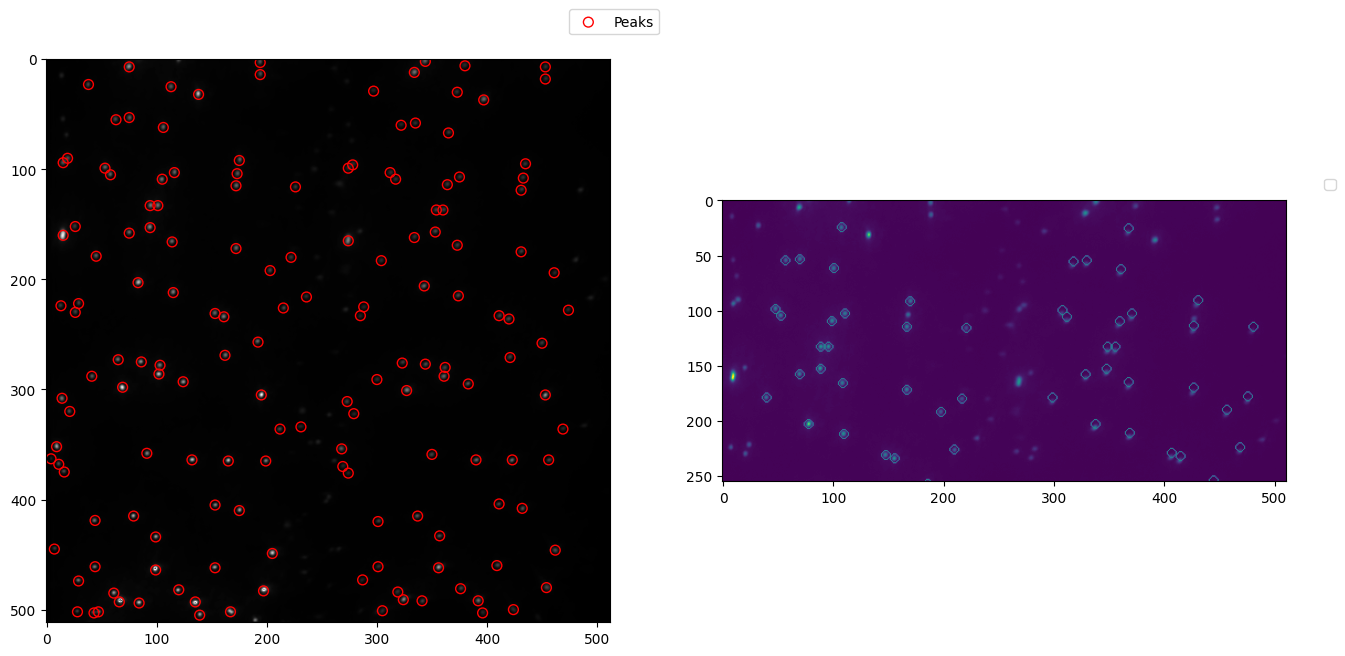

In [13]:
#Image on dropbox
#My image path 
f, axes = plt.subplots(1, 2, figsize=(16, 16))

axes[0].imshow(image, cmap="grey")
axes[0].scatter(peaks_coords_IDL[:, 1], peaks_coords_IDL[:, 0], s=50, facecolors='none', edgecolors='r', label='Peaks')
axes[0].legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

#display ../pma files/hel1_ave_LF_Circ.tif next to plt.imshow(image) side by side
axes[1].imshow(hel1_ave_image)
axes[1].legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.show()

In [14]:
# def calculate_peak_sizes(peak_coords, processed_image):
#     labeled_array, num_features = label(processed_image > 0)
#     peak_sizes = []
    
#     for peak in peak_coords:
#         y, x = peak
#         if labeled_array[y, x] > 0:
#             slice_y, slice_x = find_objects(labeled_array == labeled_array[y, x])[0]
#             width = slice_x.stop - slice_x.start
#             height = slice_y.stop - slice_y.start
#             peak_sizes.append((width, height))
    
#     return peak_sizes


In [15]:
# peak_sizes = calculate_peak_sizes(peaks_coords_IDL, processed_image)


## Filter peaks. We want this function to filter out bad peaks from good peaks. 
#### Bad peaks are:
#### peaks that cover areas larger than 4x4
#### outside of the 10 pixel boarder

In [16]:
# print(type(peaks_scipy_IDL))
good_peaks =[]
for peak in peaks_coords_IDL:
    if peak[0]<10 or peak[0]>image.shape[0]-10 or peak[1]<10 or peak[1]>image.shape[1]-10:
        good_peaks.append(peak)
good_peaks = np.array(good_peaks)
print(good_peaks)
# print(peaks_scipy_IDL)


[[352   9]
 [505 139]
 [  7  75]
 [  2 344]
 [  3 194]
 [503  43]
 [445   7]
 [  7 453]
 [  6 380]
 [503 396]
 [363   4]]


In [17]:
def good_peak_finder(image_path, sigma=2, block_size=16, std=10, scaler_percent=35, boarder=10, max_peak_radius=2):
    peak_coors = find_peaks_scipy_IDL(image_path, sigma, block_size, std, scaler_percent)
    good_peaks = []
    bad_peaks = []
    height, width = io.imread(image_path).shape
    for peak in peak_coors:
        # add condition that peak cannot be larger than 4x4
        if peak[0] < boarder or peak[0] > height - boarder or peak[1] < boarder or peak[1] > width - boarder:
            bad_peaks.append(peak)
        else:
            good_peaks.append(peak)
    good_peaks = np.array(good_peaks)
    bad_peaks = np.array(bad_peaks)
    return good_peaks, bad_peaks


/var/folders/r0/qp6_p2111v1dzb0fg2bbfqsr0000gn/T/ipykernel_3321/1642199503.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))


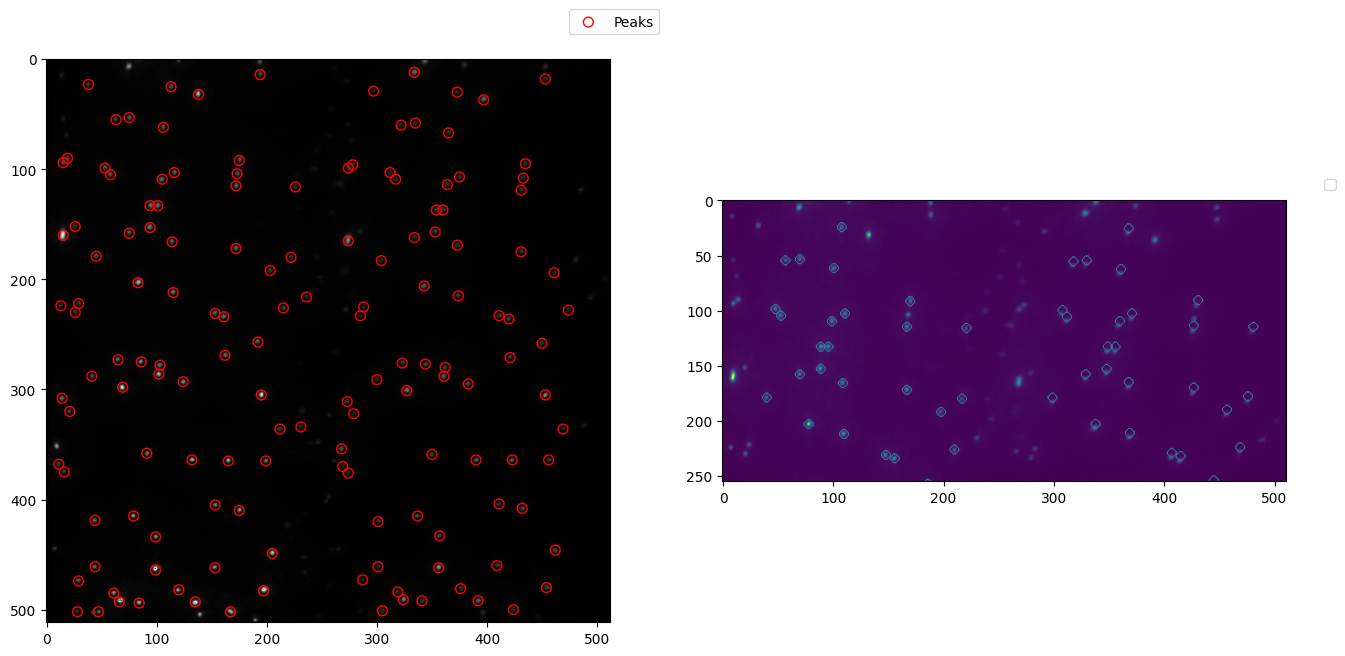

In [18]:
#Testing
good_peaks, bad_peaks = good_peak_finder(image_path)

f, axes = plt.subplots(1, 2, figsize=(16, 16))

axes[0].imshow(image, cmap="gray")
axes[0].scatter(good_peaks[:, 1], good_peaks[:, 0], s=50, facecolors='none', edgecolors='r', label='Peaks')
axes[0].legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

#display ../pma files/hel1_ave_LF_Circ.tif next to plt.imshow(image) side by side
axes[1].imshow(hel1_ave_image)
axes[1].legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.show()

## skimage.feature.peak_local_max 

#### skimage.feature.peak_local_max(image, min_distance=1, threshold_abs=None, threshold_rel=None, exclude_border=True, num_peaks=inf, footprint=None, labels=None, num_peaks_per_label=inf, p_norm=inf)

Find peaks in an image as coordinate list.

Peaks are the local maxima in a region of 2 * min_distance + 1 (i.e. peaks are separated by at least min_distance).

If both threshold_abs and threshold_rel are provided, the maximum of the two is chosen as the minimum intensity threshold of peaks.

In [19]:
def find_peaks_scikit(image_path, peak_radius, scaler_percent):

    image = io.imread(image_path, as_gray=True).astype(np.uint8)
    sigma = peak_radius / 3.0
    min_intensity = np.min(image)
    max_intensity = np.max(image)
    threshold = min_intensity + (scaler_percent / 100.0) * (max_intensity - min_intensity)


    peak_coords = feature.peak_local_max(image, min_distance=int(sigma), threshold_abs=threshold)
    
    return peak_coords

In [20]:
# peaks_scikit = find_peaks_scikit(image_path, peak_radius=2, scaler_percent=20)
# print(f"Number of peaks detected: {len(peaks_scikit)}")
# print(f"First 10 peak coordinates:\n {peaks_scikit[:10]}")
# print(f"Peaks data type: {peaks_scikit.dtype}")

In [21]:
# plt.imshow(image, cmap="gray")
# plt.scatter(peaks_scikit[:, 1], peaks_scikit[:, 0], s=50, facecolors='none', edgecolors='r', label='Peaks')
# plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
# plt.show()

It appears as though scikit (skimage) is worse at detecting peaks because it requirees we define a minimum distance between peaks. 
#This is not necessary with scipy's maximum_fiter.

Skimage often detechs multiple peaks in the same location, while scipy does not. This can be observed by the number of peaks detected by each method and also the thickness of some of the scatter points in the plot.

## We should proceed with our find_peaks_scipy funciton